# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to modify the labels of the data and do some statistical modifications.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = False    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(ATT_IMPUTED_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_IMPUTED_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12897, 17)
labels_train: (12897, 4)
instances_dev: (1612, 17)
labels_dev: (1612, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
OUTPUT_SIZE = labels_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 100 # 32,000 it aprox.
LEARNING_RATE = 0.1
BATCH_SIZE = 512
ACTIVATION = "relu"
N_HIDDEN = [512, 256, 64, 32]
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def test_model():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512_D256_D64_D32"
    return model, model_name

def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = test_model()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
start_time = time.perf_counter()
history = my_model.fit(instances_train,
                       labels_train,
                       batch_size=BATCH_SIZE,
                       epochs=N_EPOCHS,
                       verbose=1,
                       validation_data=(instances_dev, labels_dev))
end_time = time.perf_counter()

Epoch 1/100
26/26 [==============================] - 2s 12ms/step - loss: 1.2898 - categorical_accuracy: 0.4676 - val_loss: 1.1607 - val_categorical_accuracy: 0.5571
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 1.0282 - categorical_accuracy: 0.5636 - val_loss: 0.8970 - val_categorical_accuracy: 0.6117
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 0.7968 - categorical_accuracy: 0.6615 - val_loss: 0.7197 - val_categorical_accuracy: 0.6793
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 0.6652 - categorical_accuracy: 0.7164 - val_loss: 0.8036 - val_categorical_accuracy: 0.5999
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 0.6630 - categorical_accuracy: 0.6996 - val_loss: 0.7033 - val_categorical_accuracy: 0.6675
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 0.5647 - categorical_accuracy: 0.7527 - val_loss: 0.6269 - val_categorical_accuracy: 0.7177
Epoch 7/1

26/26 [==============================] - 0s 6ms/step - loss: 0.4226 - categorical_accuracy: 0.8155 - val_loss: 0.5268 - val_categorical_accuracy: 0.7736
Epoch 51/100
26/26 [==============================] - 0s 6ms/step - loss: 0.4289 - categorical_accuracy: 0.8137 - val_loss: 0.4690 - val_categorical_accuracy: 0.7723
Epoch 52/100
26/26 [==============================] - 0s 5ms/step - loss: 0.4471 - categorical_accuracy: 0.8003 - val_loss: 0.4438 - val_categorical_accuracy: 0.8052
Epoch 53/100
26/26 [==============================] - 0s 6ms/step - loss: 0.4058 - categorical_accuracy: 0.8244 - val_loss: 0.4605 - val_categorical_accuracy: 0.7878
Epoch 54/100
26/26 [==============================] - 0s 5ms/step - loss: 0.4419 - categorical_accuracy: 0.8042 - val_loss: 0.4387 - val_categorical_accuracy: 0.8046
Epoch 55/100
26/26 [==============================] - 0s 6ms/step - loss: 0.4094 - categorical_accuracy: 0.8211 - val_loss: 0.4913 - val_categorical_accuracy: 0.7816
Epoch 56/100
26/2

26/26 [==============================] - 0s 7ms/step - loss: 0.3898 - categorical_accuracy: 0.8283 - val_loss: 0.4842 - val_categorical_accuracy: 0.7909
Epoch 100/100
26/26 [==============================] - 0s 7ms/step - loss: 0.3917 - categorical_accuracy: 0.8307 - val_loss: 0.4316 - val_categorical_accuracy: 0.8102


## Step 7: Analyze results

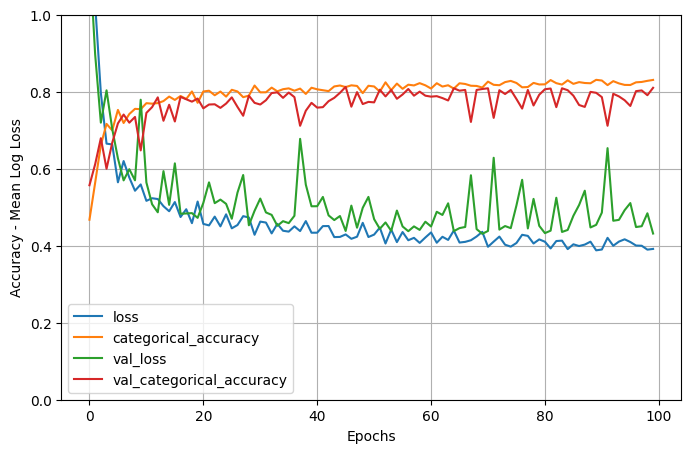

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 1)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 1)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Error (training): 16.9 %
Error (test): 19.0 %
Bias: 11.9
Variance: 2.1
Time:  19 seconds


## Step 8: Save results

In [13]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [14]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [15]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'train_error',
    'validation_error',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "SGD",
    "",
    training_error,
    test_error,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)

In [16]:
concatenation.head()

,model_name,epochs,learning_rate,batch_size,activation,loss,optimizer,regularization,train_error,validation_error,bias,variance,training_time
0,D512_D256_D64_D32,100,0.1,512,relu,categorical_crossentropy,SGD,NaN,16.4,23.1,11.4,6.7,19
1,D512_D256_D64_D32,100,0.1,512,relu,categorical_crossentropy,SGD,None,16.9,19.0,11.9,2.1,19
